In [1]:
import hydra
from glob import  glob
from proteoscope.datamodule import ProteoscopeDataModule
from proteoscope.proteoscopemodule import ProteoscopeLightningModule
import numpy as np
from omegaconf import OmegaConf


# BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-05-26/20-52-13"
BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-05-30/06-00-00"
config_dir = BASE_DIR + "/.hydra"

with hydra.initialize_config_dir(config_dir=config_dir):
    config = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

    chkpts = glob(BASE_DIR + "/checkpoints/*.ckpt")
    chkpts.sort()
    chkpt = chkpts[-1]
    print('   Using ', chkpt)


    pdm = ProteoscopeDataModule(
        images_path=config.data.images_path,
        labels_path=config.data.labels_path,
        sequences_path=config.data.sequences_path,
        batch_size=config.trainer.batch_size,
        num_workers=config.trainer.num_workers,
    )
    pdm.setup()

    plm = ProteoscopeLightningModule.load_from_checkpoint(
        chkpt,
        module_config=config.module,
        unet_number=2,
    )

/tmp/ipykernel_2607/2593037710.py:13: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=config_dir):


   Using  /home/ec2-user/outputs-proteoscope/2023-05-30/06-00-00/checkpoints/last.ckpt


In [2]:
dl = pdm.val_dataloader(novel_proteins=True, shuffle=True)
batch = next(iter(dl))

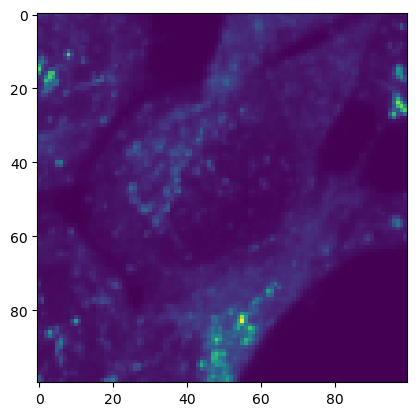

In [3]:
import matplotlib.pyplot as plt
plt.imshow(batch['image'][2, 0])

In [9]:
seq_embeds = batch['sequence_embed'].cuda()
seq_mask = batch['sequence_mask'].cuda()
images = batch['image'][:, 0, :, :].unsqueeze(dim=1).cuda()
cond_images = batch['image'][:, 1, :, :].unsqueeze(dim=1).cuda()
plm.model.cuda()

output_images = plm.model.sample(text_embeds=seq_embeds, text_masks=seq_mask, cond_images = cond_images, cond_scale = 10.)
output_images = output_images.detach().cpu().numpy()
input_images = images.detach().cpu().numpy()

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
1

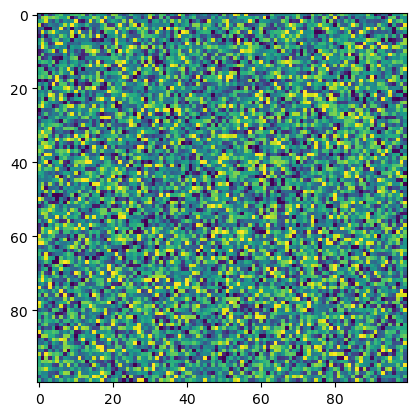

In [ ]:
plt.imshow(output_images[2, 0])

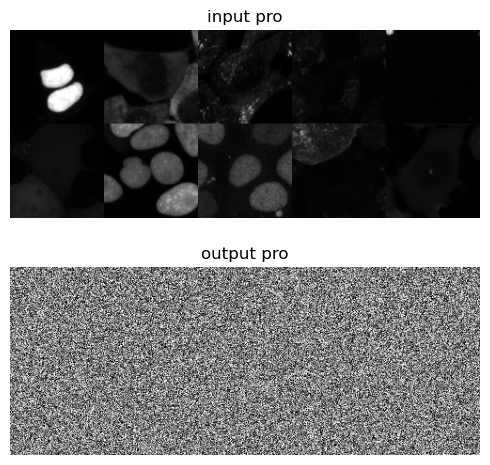

In [ ]:
data_ch = ['pro']
fig, ax = plt.subplots(2, len(data_ch), figsize=(5 * len(data_ch), 5), squeeze=False)
for ii, ch in enumerate(data_ch):
    t0 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(input_images[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t0[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    t1 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(output_images[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t1[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    ax[0, ii].imshow(t0, cmap='gray')
    ax[0, ii].axis('off')
    ax[0, ii].set_title('input ' + ch)
    ax[1, ii].imshow(t1, cmap='gray')
    ax[1, ii].axis('off')
    ax[1, ii].set_title('output ' + ch)
fig.tight_layout()
fig.show()
# fig.savefig(join(trainer.savepath_dict['visualization'], 'reconstructed_images.png'), dpi=300)

# Cytoself

In [ ]:
import torch
from tqdm import tqdm


clm.model.to('cuda')
embeddings = []
for batch in tqdm(pdm.val_dataloader()):
    emb = clm.model(batch['image'].to('cuda'), 'vqvec2')
    embeddings.append(emb.detach().cpu().numpy())
embeddings = np.concatenate(embeddings, axis=0)

In [ ]:
import zarr
from os.path import join

datapath = "/home/ec2-user/cytoself-data/"
zarr_path = join(datapath, "embeddings_2.zarr")

shape = embeddings.shape
chunks = (100, None, None, None)
z = zarr.open(zarr_path, mode="a", shape=shape, chunks=chunks)
z[:] = embeddings

# embeddings = np.asarray(zarr.open(zarr_path, mode='r'))

In [ ]:
embeddings.shape

In [ ]:
import umap


n_neighbors = 15
min_dist = 0.1
metric = 'euclidean'
reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
reducer.fit(embeddings.reshape(embeddings.shape[0], -1))

In [ ]:
reduced_embedding = reducer.transform(embeddings.reshape(embeddings.shape[0], -1))

In [ ]:
reduced_embedding.shape

In [ ]:
plt.scatter(reduced_embedding[:, 0], reduced_embedding[:, 1]);

In [ ]:
labels = pdm.val_dataloader().dataset.labels['loc_grade1']

In [ ]:
labels_full = labels.str.split(';', expand=True).stack()

In [ ]:
labels_full.unique()

In [ ]:
(labels == '').sum()

In [ ]:
labels_full

In [ ]:
labels_full.unique()

In [ ]:
pdm.val_dataloader().dataset.labels.head()

In [ ]:
pdm.val_dataloader().dataset.labels

In [ ]:
label_groups = ['cytoplasmic',
          'er',
          'golgi',
          'mitochondia',
        #   'nuclear domains',
          'nuclear_membrane',
        #   'nucleus',
        #   'nucleoplasm',
          'vesicles',
        #   'others',
          ]

In [ ]:
labels.loc[labels.str.contains(';', na=False)] = 'others'

In [ ]:
labels.unique()

In [ ]:
import seaborn as sns

In [ ]:
keep = labels.isin(label_groups)

In [ ]:
sns.set(rc={"figure.figsize":(14, 14)})
sns.scatterplot(x=reduced_embedding[keep, 0], y=reduced_embedding[keep, 1], hue=labels[keep], s=2, alpha=0.9)

In [ ]:
embeddings[:, 1].shape

In [ ]:
from cytoself.analysis.analysis_opencell import AnalysisOpenCell

analysis = AnalysisOpenCell(datamanager, trainer)
umap_data = analysis.plot_umap_of_embedding_vector(
    data_loader=datamanager.test_loader,
    group_col=2,
    output_layer=f'{model_args["fc_input_type"]}2',
    title=f'UMAP {model_args["fc_input_type"]}2',
    xlabel='UMAP1',
    ylabel='UMAP2',
    s=0.3,
    alpha=0.5,
    show_legend=True,
)

In [ ]:
from proteoscope.datamodule import ProteoscopeDataModule

In [ ]:
import os

datapath = '/home/ec2-user/cytoself-data'
images_path = os.path.join(datapath, 'images.zarr')
labels_path = os.path.join(datapath, 'labels.csv')

pdm = ProteoscopeDataModule(images_path, labels_path)
pdm.setup()

In [ ]:
# import pandas as pd

# df = pd.read_csv(labels_path, index_col=0)
# df.to_csv(labels_path)

In [ ]:
dl = pdm.train_dataloader()
batch = next(iter(dl))

In [ ]:
pdm.train_loader = pdm.train_dataloader()
pdm.train_variance = 0.0161394402384758

In [ ]:
pdm.train_labels = len(pdm.train_dataset.labels['label'].unique())

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.imshow(batch['image'][0, 1])

## Train

In [ ]:
from os.path import join
import numpy as np
import torch
import matplotlib.pyplot as plt

from cytoself.datamanager.opencell import DataManagerOpenCell
from cytoself.trainer.cytoselflite_trainer import CytoselfFullTrainer
from cytoself.analysis.analysis_opencell import AnalysisOpenCell
from cytoself.trainer.utils.plot_history import plot_history_cytoself

# data_ch = ['pro', 'nuc'] # , 'nucdist', 'label']
# # datapath = '/home/ec2-user/cytoself'
# datapath = 'sample_data'
# datamanager = DataManagerOpenCell(datapath, data_ch, fov_col=None)
# datamanager.const_dataloader(batch_size=32, label_name_position=1)

In [ ]:
# datamanager.train_variance
# datamanager.train_loader.dataset[2]['image'].shape
# plt.imshow(datamanager.train_loader.dataset[2]['image'][0])

In [ ]:
# num_classes = len(datamanager.unique_labels)
num_classes = pdm.train_labels
model_args = {
    'input_shape': (2, 100, 100),
    'emb_shapes': ((25, 25), (4, 4)),
    'output_shape': (2, 100, 100),
    'fc_output_idx': [2],
    'vq_args': {'num_embeddings': 512, 'embedding_dim': 64},
    'num_class': num_classes,
    'fc_input_type': 'vqvec',
}
train_args = {
    'lr': 1e-3,
    'max_epoch': 10,
    'reducelr_patience': 3,
    'reducelr_increment': 0.1,
    'earlystop_patience': 6,
}
trainer = CytoselfFullTrainer(train_args, homepath='demo_output', model_args=model_args)
# trainer.fit(pdm, tensorboard_path='tb_logs')

In [ ]:
from cytoself.trainer.autoencoder.cytoselffull import CytoselfFull

In [ ]:
model_args = {
    'input_shape': (2, 100, 100),
    'emb_shapes': ((25, 25), (4, 4)),
    'output_shape': (2, 100, 100),
    'fc_output_idx': [2],
    'vq_args': {'num_embeddings': 512, 'embedding_dim': 64},
    'num_class': 100,
    'fc_input_type': 'vqvec',
}

model = CytoselfFull(**model_args)

In [ ]:
from cytoself.trainer.autoencoder.cytoselffull import duplicate_kwargs

In [ ]:
duplicate_kwargs(model_args['vq_args'], model_args['emb_shapes'])

In [ ]:
type(model_args['vq_args'])

In [ ]:
import torch.nn as nn

image_criterion = nn.MSELoss()
labels_criterion = nn.CrossEntropyLoss()

In [ ]:
images = batch['image']
labels = batch['label']
output_images, output_logits = model(images)

In [ ]:
image_variance = 1
model.mse_loss['reconstruction1_loss'] = image_criterion(output_images, images) / image_variance
model.fc_loss = {f'fc{model.fc_output_idx[0]}_loss' :labels_criterion(output_logits, labels)}
vq_loss = torch.stack([d['loss'] for d in model.vq_loss.values()]).sum()
mse_loss = torch.stack([d for d in model.mse_loss.values()]).sum()
fc_loss = torch.stack([d for d in model.fc_loss.values()]).sum()

In [ ]:
vq_coeff = 1
fc_coeff = 1

loss = mse_loss + fc_coeff * fc_loss + vq_coeff * vq_loss

In [ ]:
loss

In [ ]:
vq_loss

In [ ]:
model.vq_loss

In [ ]:
model.perplexity

In [ ]:
model.fc_output_idx

In [ ]:
model.fc_loss

In [ ]:
output = {'loss': loss.item()}
output.update({k: v.item() for k, v in model.fc_loss.items()})
output.update({k: v.item() for k, v in model.perplexity.items()})
output.update({k: model.mse_loss[k].item() for k in sorted(model.mse_loss)})
vq_loss_dict = {}
for key0, val0 in model.vq_loss.items():
    for key1, val1 in val0.items():
        vq_loss_dict[key0 + '_' + key1] = val1.item()
output.update(vq_loss_dict)

In [ ]:
output

In [ ]:
trainer = CytoselfFullTrainer(train_args, homepath='demo_output', model_args=model_args)
output = trainer.run_one_batch(batch, 0.5)

In [ ]:
trainer = CytoselfFullTrainer(train_args, homepath='demo_output', model_args=model_args)
output2 = trainer.run_one_batch(batch, 0.5)

In [ ]:
output

In [ ]:
output2


In [ ]:
plot_history_cytoself(trainer.history, savepath=trainer.savepath_dict['visualization'])

In [ ]:
img = next(iter(datamanager.test_loader))['image'].detach().cpu().numpy()
torch.cuda.empty_cache()
reconstructed = trainer.infer_reconstruction(img)
fig, ax = plt.subplots(2, len(data_ch), figsize=(5 * len(data_ch), 5), squeeze=False)
for ii, ch in enumerate(data_ch):
    t0 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(img[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t0[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    t1 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(reconstructed[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t1[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    ax[0, ii].imshow(t0, cmap='gray')
    ax[0, ii].axis('off')
    ax[0, ii].set_title('input ' + ch)
    ax[1, ii].imshow(t1, cmap='gray')
    ax[1, ii].axis('off')
    ax[1, ii].set_title('output ' + ch)
fig.tight_layout()
fig.show()
fig.savefig(join(trainer.savepath_dict['visualization'], 'reconstructed_images.png'), dpi=300)

In [ ]:
analysis = AnalysisOpenCell(datamanager, trainer)

In [ ]:
analysis.plot_clustermap(num_workers=4)

## Custom trainer

In [ ]:
from proteoscope.cytoselfmodule import CytoselfLightningModule

In [ ]:
clm = CytoselfLightningModule(model_args)

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [ ]:
trainer = Trainer()

In [ ]:
trainer.fit(clm, pdm)

In [ ]:
from cytoself.analysis.analysis_opencell import AnalysisOpenCell

analysis = AnalysisOpenCell(datamanager, trainer)
umap_data = analysis.plot_umap_of_embedding_vector(
    data_loader=datamanager.test_loader,
    group_col=2,
    output_layer=f'{model_args["fc_input_type"]}2',
    title=f'UMAP {model_args["fc_input_type"]}2',
    xlabel='UMAP1',
    ylabel='UMAP2',
    s=0.3,
    alpha=0.5,
    show_legend=True,
)

In [ ]:
# Compute bi-clustering heatmap
analysis.plot_clustermap(num_workers=4)

# Prepare image data
img = next(iter(datamanager.test_loader))['image'].detach().cpu().numpy()[:1]

# Compute index histogram
vqindhist1 = trainer.infer_embeddings(img, 'vqindhist1')

# Reorder the index histogram according to the bi-clustering heatmap
ft_spectrum = analysis.compute_feature_spectrum(vqindhist1)

# Generate a plot
import numpy as np
import matplotlib.pyplot as plt

x_max = ft_spectrum.shape[1] + 1
x_ticks = np.arange(0, x_max, 50)
fig, ax = plt.subplots(figsize=(10, 3))
ax.stairs(ft_spectrum[0], np.arange(x_max), fill=True)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('Feature index')
ax.set_ylabel('Counts')
ax.set_xlim([0, x_max])
ax.set_xticks(x_ticks, analysis.feature_spectrum_indices[x_ticks])
fig.tight_layout()
fig.show()